# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Self-driving car project, behavior cloning for driving. 

The main task is to drive a car around in a simulator on a race track, and then use deep learning to mimic the behavior of human.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: The input image first view

In [1]:
# Load images
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import matplotlib.image as mpimg
%matplotlib inline

                
    
# load the whole csv as array ,pop up the first line of labels
import csv
train_data_directory = './data/data/IMG/'
val_data_directory='./data/valdata/IMG/'
log_directory='./data/data/'
val_direcory='./data/valdata/'
log_path='./data/data/driving_log.csv'
val_log_path='./data/valdata/driving_log.csv'


logs = []
zero_logs=[]
none_zero_logs=[]
with open(log_path,'rt') as f:
    reader = csv.reader(f)
    for line_data in reader:
        logs.append(line_data)

        
log_labels = logs.pop(0)
for i in range(len(logs)):
    if float(logs[i][3])>-0.01 and float(logs[i][3])<0.01:
        zero_logs.append(logs[i])
    else:
        none_zero_logs.append(logs[i])
    
#nonZeroSamples =  logs.loc[drivingLog['Steering'] != 0.0,:] 
#zeroSamples =  logs.loc[drivingLog['Steering'] == 0.0,:]  


print(log_labels)
print(" data images number ",len(logs))
print("zero log number ",len(zero_logs))
print("none zero number ",len(none_zero_logs))





val_logs = []
with open(val_log_path,'rt') as f:
    reader = csv.reader(f)
    for line_data in reader:
        val_logs.append(line_data)
val_log_labels = logs.pop(0)
print("validation data images number ",len(val_logs))






['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
 data images number  8036
zero log number  4452
none zero number  3584
validation data images number  5590


IMG/center_2016_12_01_13_32_58_621.jpg
['', 'center_2016_12_01_13_32_58_621.jpg']
center_2016_12_01_13_32_58_621.jpg
left_2016_12_01_13_32_58_621.jpg
right_2016_12_01_13_32_58_621.jpg
0.0617599
D:\selfdriving\behavior cloning video and project\simulator-windows-64\IMG\center_2017_01_21_00_02_55_873.jpg
center_2017_01_21_00_02_55_873.jpg


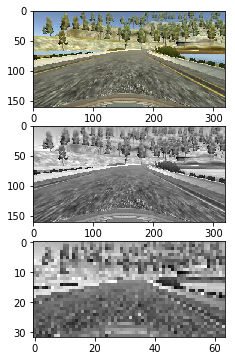

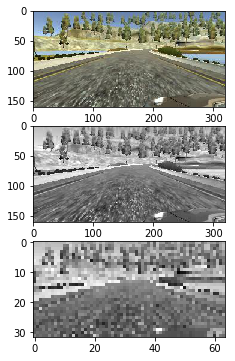

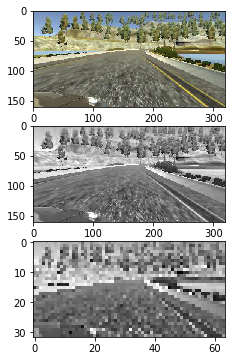

In [2]:

def imageshow(image):
    plt.figure(figsize=(12,6))
    img_processed1 = (cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:,:,2]  # v channel
    img_processed2 = (cv2.cvtColor(cv2.resize(image,(64,32)), cv2.COLOR_RGB2HSV))[:,:,2]
    plt.subplot(3,1,1)
    plt.imshow(image)
    plt.subplot(3,1,2)
    plt.imshow(img_processed1,cmap='gray')
    plt.subplot(3,1,3)
    plt.imshow(img_processed2,cmap='gray') 

print(logs[200][0])
print(logs[200][0].split("IMG/"))
print(logs[200][0].split("IMG/")[1].strip())
print(logs[200][1].split("IMG/")[1].strip())
print(logs[200][2].split("IMG/")[1].strip())
print(logs[50][3].strip())
print(val_logs[200][0])
print(val_logs[200][0].split("D:\\selfdriving\\behavior cloning video and project\\simulator-windows-64\\IMG\\")[1].strip())


image = mpimg.imread(train_data_directory +logs[200][0].split("IMG/")[1].strip())
imageshow(image) 

image = mpimg.imread(train_data_directory +logs[200][1].split("IMG/")[1].strip())
imageshow(image) 

image = mpimg.imread(train_data_directory +logs[200][2].split("IMG/")[1].strip())
imageshow(image) 

Obersavation 1:
    from the input image sample, we can see that:

1.The bonnet of the car is visible at the bottom of the image.we can cut the part of bottom with little infulunce on road detection.
2.there are sky part on the upper part which is also no use for road detecion .
    Only the edges of the road are relevant for determing the steering angle.
    The portion of the image above the horizon (where the road ends) can be cutted in the image pre-processing.
3. sometimes the road edges is not very clear,maybe we should add more cv image processing
    

---

## Step 1: driving_log.csv Summary & Exploration

Complete the basic data summary below.

In [3]:
import pandas as pd
import numpy as np
#print("dataframe shape ",drivingLog.shape)
#print(drivingLog.ix[0])


data = pd.read_csv('./data/data/driving_log.csv', usecols=["steering","throttle","brake","speed"])
data.describe(np.arange(0,1,.1),include='all')
#drivingLog.loc[:,["Steering"]].describe(np.arange(0,1,.1),include='all')



,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
0%,-0.942695,0.000000,0.000000,0.502490
10%,-0.135712,0.202568,0.000000,23.471400
20%,-0.031274,0.985533,0.000000,30.178100
30.0%,0.000000,0.985533,0.000000,30.184740
40%,0.000000,0.985533,0.000000,30.185980
50%,0.000000,0.985533,0.000000,30.186400


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ACB6459E48>]], dtype=object)

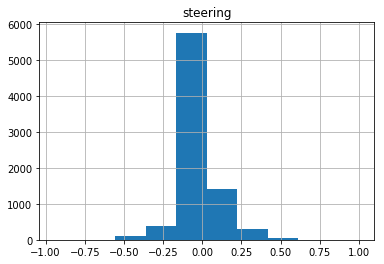

In [4]:
data.hist(column='steering')

step 3: recreate data according to balance  
from the data histgram ,we can see 60%-70%  of original data's steering angle is near 0.
#（to balance data and to reserve the original infomation, a good solution is augmented the other part of data 6 times as the number of  0 steering angle data.）
it is hard to load all the image into memery,so here keras generator is used.
the following preprocessings are included:
1)train data steering angles are selected to a normal-like distribution.
2)cut the upper 20% of image and the bottom 20 pixels
3)resize the image to 64*32 
4)randomly flip the image to get balanced left turn and right turn data 
5）use the left and right camera data with an offset of +-0.25 steering angle
5)using only V channel of hsv?



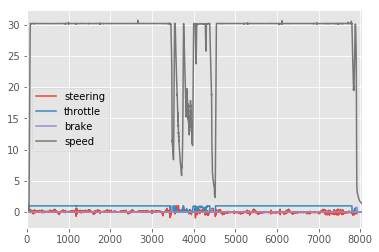

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.style.use('ggplot')
plt.figure(figsize=(20,10))
data.plot()



In [6]:
#def log_select(zero_logs,none_zero_logs,zero_factor=0.2,train_factor=0.9):
def log_select(zero_logs,none_zero_logs,zero_factor=1,train_factor=0.9):
    random.shuffle(zero_logs)
    random.shuffle(none_zero_logs)
    
    num_train_zero_log=int(zero_factor*train_factor*len(zero_logs))
    num_train_non_zero_log=int(train_factor*len(none_zero_logs))
    num_train_log=num_train_zero_log+num_train_non_zero_log

    num_val_zero_log=int(zero_factor*(1-train_factor)*len(zero_logs))
    num_val_non_zero_log=len(none_zero_logs)-num_train_non_zero_log-1
    num_val_log=num_val_zero_log+num_val_non_zero_log

    train_logs=zero_logs[0:num_train_zero_log]+none_zero_logs[0:num_train_non_zero_log]
    val_part1=random.sample(zero_logs[num_train_zero_log:-1],num_val_zero_log)
    val_part2=random.sample(none_zero_logs[num_train_non_zero_log:-1],num_val_non_zero_log)
    val_logs=val_part1+val_part2

    #print(num_train_zero_log)
    #print(num_train_non_zero_log)
    #print(num_val_zero_log)
    #print(num_val_non_zero_log)
    random.shuffle(train_logs)
    random.shuffle(val_logs)
    return train_logs, val_logs

train_logs, val_logs=log_select(zero_logs,none_zero_logs)
    
print(len(train_logs))
print(len(val_logs))


7231
803


(array([  4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.40000000e+01,   1.00000000e+00,
          2.00000000e+00,   2.60000000e+01,   3.00000000e+00,
          1.40000000e+01,   1.60000000e+01,   9.00000000e+00,
          1.20000000e+01,   1.40000000e+01,   2.10000000e+01,
          7.30000000e+01,   4.40000000e+01,   2.00000000e+01,
          4.30000000e+01,   8.50000000e+01,   1.40000000e+01,
          3.30000000e+01,   7.80000000e+01,   2.08000000e+02,
          8.00000000e+01,   1.21000000e+02,   2.51000000e+02,
          1.88000000e+02,   7.50000000e+01,   6.60000000e+01,
        

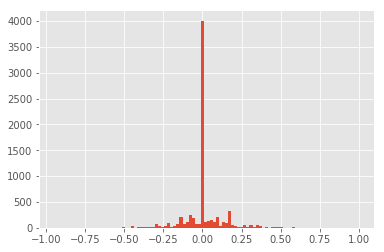

In [7]:
#visualize the selected steering angle distribition
def get_steering_from_logs(logs):
    steering_list=[]
    for i in range(len(logs)):
        steering_angle=float(logs[i][3].strip())
        steering_list.append(steering_angle)
    return steering_list
        
        


train_logs, val_logs=log_select(zero_logs,none_zero_logs)
train_logs_steering_list=get_steering_from_logs(train_logs)
val_logs_steering_list=get_steering_from_logs(val_logs)

plt.hist(train_logs_steering_list,bins=100)
    
    
    

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
           3.,    0.,    5.,    1.,    2.,    1.,    1.,    0.,    1.,
           5.,    4.,    5.,    1.,    0.,    9.,    5.,    1.,    3.,
           7.,   16.,    7.,    5.,    0.,   22.,   35.,   10.,    5.,
          14.,  445.,    9.,    9.,   16.,   10.,    2.,   26.,    5.,
          14.,    3.,   28.,   23.,   10.,    2.,    0.,    2.,    5.,
           4.,    0.,    2.,    2.,    1.,    4.,    1.,    2.,    1.,
           1.,    1.,    1.,    2.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([-0.6009356 , -0.58492624, -0.56891689, -0.55290753, -0.53689818,
        -0.52088882, -0.50487946, -0.48887011, -0.47286075, -0.4568514 ,
        -0.44084204, -0.42483268, -0.40882333, -0.39281397, -0.3

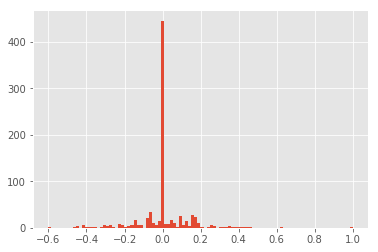

In [8]:
plt.hist(val_logs_steering_list,bins=100)

In [9]:
#pre processing
import math
col,row=320,160
new_size_col,new_size_row = 200, 66

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(col,row))
    return image_tr,steer_ang

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/5):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    return image

def preprocess_image_random(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = log_directory+line_data[0].strip()
        shift_ang = 0
    if (i_lrc == 1):
        path_file = log_directory+line_data[1].strip()
        shift_ang = 0.25
    if (i_lrc == 2):
        path_file = log_directory+line_data[2].strip()
        shift_ang = -.25
    y_steer = float(line_data[3].strip()) + shift_ang
    #image = cv2.imread(path_file)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = plt.imread(path_file)
    image,y_steer = trans_image(image,y_steer,100)
    image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    #image=add_random_shadow(image)
    image = np.array(image)
    
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    #image = image.astype(np.float32)
    #image = image/255.0 - 0.5
    return image,y_steer

In [10]:
#import random

#def some(x, n):
    #return x.ix[random.sample(x.index, n)]



In [11]:


def generateBatch(logs,batch_size = 32,threshhold=0.05):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(logs))
            line_data = logs[i_line]
            x,y = preprocess_image_random(line_data)
            keep_pr = 0
            while keep_pr == 0:
                x,y = preprocess_image_random(line_data)

                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>threshhold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering
        
        
        
"""
def generateBatchVal(val_logs,batch_size = 32):
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    
    startIdx = 0
    batchCount = len(val_logs)/batch_size 
    while True: 
        endIdx = startIdx + batch_size

        for i in range(batch_size):
            img_path=val_data_directory+val_logs[startIdx+i][0].split("D:\\selfdriving\\behavior cloning video and project\\simulator-windows-64\\IMG\\")[1].strip()
            img = plt.imread(img_path)
            x=preprocessImage(img)
            y=float(logs[startIdx+i][3])
            batch_images[i] = x
            batch_steering[i] = y
        yield batch_images, batch_steering
        startIdx = endIdx
        if len(val_logs)-startIdx <batch_size:
            startIdx = 0
"""

'\ndef generateBatchVal(val_logs,batch_size = 32):\n    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))\n    batch_steering = np.zeros(batch_size)\n    \n    startIdx = 0\n    batchCount = len(val_logs)/batch_size \n    while True: \n        endIdx = startIdx + batch_size\n\n        for i in range(batch_size):\n            img_path=val_data_directory+val_logs[startIdx+i][0].split("D:\\selfdriving\\behavior cloning video and project\\simulator-windows-64\\IMG\\")[1].strip()\n            img = plt.imread(img_path)\n            x=preprocessImage(img)\n            y=float(logs[startIdx+i][3])\n            batch_images[i] = x\n            batch_steering[i] = y\n        yield batch_images, batch_steering\n        startIdx = endIdx\n        if len(val_logs)-startIdx <batch_size:\n            startIdx = 0\n'

[ -4.07525589e-01  -1.04529627e-01  -2.07767157e-01  -1.86791388e-01
   1.45049385e-01  -3.81609916e-01  -1.27773510e-01  -3.72650274e-01
  -2.09055819e-01  -2.40528211e-01   3.72217580e-01  -1.09854479e-01
  -6.07299857e-03  -4.70023443e-03  -1.16516220e-01  -2.45132441e-01
   1.90300509e-01   2.30937965e-02   3.57748706e-02  -1.38738241e-01
  -9.59359598e-02  -3.59958261e-02  -1.87264181e-01  -2.18396981e-01
   7.04655782e-02  -4.00434023e-01   1.97211041e-01  -1.63905849e-01
   3.33969568e-01   3.89833072e-02   2.64692962e-01   1.55167518e-01
   3.34205829e-01  -5.86235895e-02  -3.94581957e-01   2.74122801e-01
  -8.06165153e-02   1.16222055e-01  -6.39631835e-02  -5.04118700e-01
   5.36019954e-01   3.82676842e-01  -4.24551591e-01   1.63349454e-01
   2.28121742e-02   4.70916267e-01   3.81842123e-01   9.47675567e-02
  -4.56621663e-01  -3.50761617e-01   1.86104162e-03   7.72418953e-02
  -2.06750649e-02  -1.15523371e-01  -4.73636975e-01   1.36586161e-01
  -1.77741269e-01  -2.89073590e-01

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   2.,   2.,   1.,   4.,   2.,
          1.,   3.,   1.,   3.,   1.,   1.,   1.,   3.,   4.,   7.,   2.,
          1.,   3.,   3.,   4.,   7.,   3.,   9.,   6.,   8.,   5.,   5.,
         12.,   9.,   3.,   3.,   1.,   9.,   0.,   1.,   2.,   5.,   3.,
          8.,   5.,   3.,   4.,   6.,   9.,   8.,   4.,   5.,   4.,   1.,
          3.,   1.,   0.,   0.,   5.,   3.,   2.,   6.,   4.,   2.,   1.,
          0.,   4.,   4.,   3.,   2.,   2.,   1.,   1.,   0.,   1.,   0.,
          1.]),
 array([-0.84957898, -0.83561272, -0.82164646, -0.80768021, -0.79371395,
        -0.77974769, -0.76578143, -0.75181517, -0.73784891, -0.72388266,
        -0.7099164 , -0.69595014, -0.68198388, -0.66801762, -0.65405136,
        -0.6400851 , -0.62611885, -0.61215259, -0.59818633, -0.58422007,
        -0.57025381, -0.55

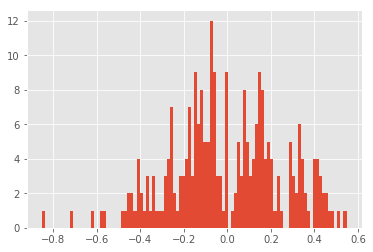

In [18]:
# visualize the generateBatch steering distribution
def get_steeringList(batch_generator,size):
    steeringList = np.empty((0))
    for i in range(1,size):
        steeringList = np.append(steeringList,next(batch_generator)[1])
        print(next(batch_generator)[1])
    return steeringList
    
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.05)
batch_steering=get_steeringList(batch_generator,size=2)   
plt.hist(batch_steering.astype('float'),bins=100)


[ 0.56863183  0.37529883  0.23765255  0.53700627  0.31576403 -0.07246761
 -0.25148102 -0.2967201   0.43083059 -0.10235734  0.40283938 -0.19937973
 -0.30472392 -0.12052091  0.23289432 -0.12235095  0.42379415  0.24387929
  0.13981645 -0.1399269   0.19657423  0.14104397 -0.07552287 -0.41036866
 -0.05334109  0.2694774   0.45218951 -0.1567227   0.29766275  0.03313611
 -0.41251462  0.38488074  0.25437909 -0.38822511  0.06444005 -0.22123448
  0.10597999 -0.14171943 -0.66558799 -0.32190327  0.37395392 -0.1118273
 -0.09617907 -0.2909462   0.03611926 -0.19930686  0.12863663  0.15311469
  0.15459987  0.62402576  0.27092186  0.08910252 -0.01339856 -0.1934278
  0.21949736 -0.33082881  0.23896098 -0.37218977 -0.06247572  0.11784039
 -0.0421464   0.24963013  0.12528861  0.44941643  0.24889708 -0.00532353
 -0.39794593 -0.00120717 -0.32985868 -0.24082005  0.24195397 -0.23768694
  0.3003485  -0.5113912   0.83216248  0.36839217  0.40273593 -0.25265721
 -0.19370175  0.21844876  0.25328135  0.02418718  0.0

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   2.,   1.,   2.,   0.,   2.,   1.,   0.,
          7.,   9.,  11.,   4.,   5.,  11.,  12.,   6.,   8.,   6.,  12.,
          9.,  14.,  12.,  19.,  22.,  14.,  13.,  20.,  11.,   9.,  10.,
          8.,  16.,  13.,  20.,  16.,  18.,  19.,  19.,   9.,   8.,  15.,
          8.,   7.,   8.,   6.,  13.,   6.,   5.,  14.,   4.,   3.,   2.,
          3.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.93883002, -0.91688558, -0.89494114, -0.87299669, -0.85105225,
        -0.82910781, -0.80716337, -0.78521893, -0.76327448, -0.74133004,
        -0.7193856 , -0.69744116, -0.67549672, -0.65355228, -0.63160783,
        -0.60966339, -0.58771895, -0.56577451, -0.54383007, -0.52188562,
        -0.49994118, -0.47

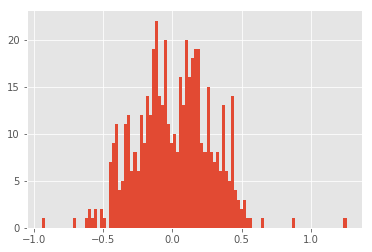

In [21]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.05)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

[-0.08310598 -0.23491345 -0.40584215  0.31984458  0.4271729   0.52743201
  0.22676591  0.26940376 -0.42821261 -0.21205248  0.37678855 -0.21917747
 -0.0265612  -0.37876708  0.46018688 -0.78406266  0.14645634 -0.16366781
  0.12876755 -0.25647862 -0.44619251  0.20323371  0.33362009 -0.09857747
  0.19383042 -0.19290444 -0.15843981  0.12198599  0.12578397  0.13307408
  0.08792113  0.51101877  0.0941506   0.13019955 -0.57839489 -0.0070223
 -0.16993398 -0.53136047 -0.18844595  0.24707628  0.09326776 -0.28040115
 -0.05098113 -0.0790725   0.0489645  -0.53827206 -0.34568657 -0.01746301
 -0.41917433  0.54166328  0.03378602 -0.06232965 -0.22962444 -0.00976504
 -0.25956648 -0.12439389 -0.10919133  0.17756528  0.60874368  0.15969008
 -0.37313127 -0.16479255  0.23154812 -0.23297677 -0.10791682  0.1131229
 -0.0586525   0.17265871 -0.43361729 -0.25527174 -0.42435836 -0.25335525
 -0.20505127 -0.03213426 -0.30717048  0.31119245 -0.03575504 -0.01921232
  0.13546346 -0.06025898  0.06159498 -0.32812914 -0.0

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   1.,   1.,   2.,   3.,   0.,   0.,   1.,   2.,   3.,   0.,
          3.,   4.,   5.,   8.,   3.,   5.,   5.,   8.,   5.,   7.,   3.,
         10.,  13.,   8.,  10.,  10.,   4.,  13.,  18.,  10.,  14.,   8.,
         10.,   7.,  16.,  10.,  11.,   8.,   7.,   4.,  13.,   7.,  11.,
          9.,   8.,  11.,   9.,  14.,  10.,  10.,   8.,   4.,  10.,   8.,
          2.,   4.,  11.,   8.,   5.,   7.,   8.,   9.,   5.,  11.,   4.,
          4.,   4.,   5.,   1.,   1.,   0.,   2.,   3.,   0.,   0.,   0.,
          1.,   2.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.80277168, -0.7870596 , -0.77134752, -0.75563544, -0.73992336,
        -0.72421127, -0.70849919, -0.69278711, -0.67707503, -0.66136295,
        -0.64565086, -0.62993878, -0.6142267 , -0.59851462, -0.58280254,
        -0.56709045, -0.55137837, -0.53566629, -0.51995421, -0.50424213,
        -0.48853004, -0.47

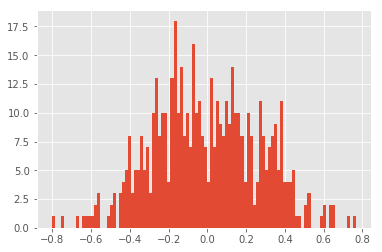

In [20]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.1)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

[  2.32271307e-01  -2.68252646e-01  -9.58248365e-02  -1.22705383e-01
  -1.85802853e-01  -3.88820920e-01   9.40983657e-03  -1.58344482e-01
  -9.38736773e-02  -1.42314179e-01   3.22524672e-01  -4.49814012e-01
  -1.29331391e-01   9.58107990e-02   8.27634685e-02  -5.91707165e-02
   2.65581245e-03   4.51822484e-01  -4.61206236e-02  -4.49562931e-01
   1.61034084e-01   2.65971278e-02   1.75756718e-01   5.72015666e-03
  -4.15438196e-01  -1.41858968e-01  -1.78764380e-01   2.64930276e-02
  -2.55714504e-01  -3.95257143e-01  -7.98372405e-01   8.20889220e-02
   4.12079425e-02  -1.30145679e-01   4.06272591e-01   6.75872285e-02
  -1.65218594e-01   5.58841592e-01  -8.78806154e-01   2.35386469e-01
   5.58272695e-01   2.26124087e-01   2.42990892e-01  -1.58376359e-01
   7.51735935e-02   6.40037689e-02  -1.77915866e-01   1.81251295e-01
   1.22333924e-01   8.90586763e-02   4.24800290e-01  -3.91155223e-01
   3.12690271e-01   1.28027347e-01   1.37348055e-01   3.17294323e-01
  -1.97675815e-01  -2.14648290e-01

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   3.,   0.,   1.,   2.,   4.,   7.,   5.,
          6.,   5.,   9.,   4.,   8.,   8.,   8.,   4.,  12.,   8.,  12.,
         11.,  12.,  15.,  21.,  16.,  10.,  12.,  22.,  15.,   8.,   6.,
         12.,  14.,  10.,  14.,  15.,  13.,  17.,  11.,   9.,   8.,  12.,
          7.,   5.,   4.,   7.,   7.,  10.,   7.,  11.,   6.,  10.,   9.,
          7.,   7.,   1.,   0.,   1.,   1.,   0.,   1.,   3.,   0.,   0.,
          0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.81949801, -0.80083505, -0.78217209, -0.76350913, -0.74484616,
        -0.7261832 , -0.70752024, -0.68885728, -0.67019432, -0.65153136,
        -0.6328684 , -0.61420544, -0.59554248, -0.57687952, -0.55821656,
        -0.53955359, -0.52089063, -0.50222767, -0.48356471, -0.46490175,
        -0.44623879, -0.42

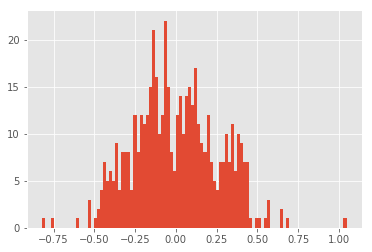

In [22]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.005)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

[ 0.0730648  -0.14586669 -0.40138583  0.3085027  -0.1490516  -0.27885179
  0.19753194 -0.10662822 -0.41227699 -0.15662505 -0.0736288   0.10678272
 -0.25439965 -0.39684341  0.38430731 -0.02015939 -0.2116853   0.06422068
 -0.05755671  0.28893788 -0.10954895  0.13305768  0.58849305 -0.19572485
 -0.11827634  0.1649916   0.05643943  0.47889012  0.07356264  0.45975745
 -0.27051924  0.35844691  0.10960077  0.0252572  -0.23417488 -0.4918552
 -0.19847951  0.47338376  0.17362133 -0.11265092 -0.21009957 -0.24273755
  0.18661128 -0.4160309  -0.15602653 -0.16581274 -0.30840155 -0.75439585
 -0.38474473 -0.43725576 -0.27843642 -0.38564466  0.05136185 -0.19456184
  0.22922268 -0.11142158  0.15183201  0.19366391 -0.33493181 -0.29196042
  0.18601656  0.10099719  0.30692897 -0.12093646 -0.29185448  0.25668428
 -0.39215611 -0.081589    0.06392749  0.4448772  -0.07617677 -0.08493223
 -0.38762501  0.12545984  0.27321955  0.15533489  0.58837207  0.00586109
  0.1140299  -0.37420747  0.80130094  0.40206102  0.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   2.,   1.,   1.,   0.,   0.,
          1.,   2.,   1.,   2.,   3.,   2.,  10.,   9.,   6.,   9.,   3.,
          5.,  11.,   8.,   8.,   4.,   5.,   5.,  12.,   4.,  12.,  20.,
         12.,  13.,  17.,  10.,  14.,  11.,  11.,  10.,   8.,  12.,  10.,
          7.,   5.,   6.,   8.,  11.,   8.,   9.,  10.,  10.,  14.,   8.,
          8.,   7.,   8.,   7.,   4.,   8.,  11.,   7.,   3.,   6.,   9.,
          5.,   9.,   7.,   6.,   2.,   4.,   1.,   1.,   4.,   1.,   3.,
          2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]), array([ -8.98236109e-01,  -8.81899953e-01,  -8.65563797e-01,
         -8.49227640e-01,  -8.32891484e-01,  -8.16555328e-01,
         -8.00219172e-01,  -7.83883016e-01,  -7.67546860e-01,
         -7.51210704e-01,  -7.34874548e-01,  -7.18538392e-01,
         -7.02202235e-01,  -6.85866079e-01,  -6.69529923e-01,
         

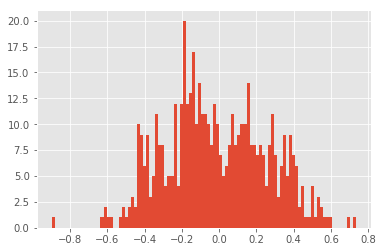

In [23]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.0005)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

[-0.31677206  0.45195972  0.31581766  0.11913653  0.26978761  0.1645175
 -0.46974639 -0.42078748 -0.16079784 -0.16738961 -0.32525658  0.1598249
  0.20601068 -0.2240433   0.29691057 -0.27401767  0.135319   -0.19498236
 -0.17057669 -0.35319793 -0.43048821  0.16540997  0.19184075 -0.10483026
 -0.32703419  0.14281301 -0.12840354  0.13249392 -0.30791032 -0.23514386
  0.14971533  0.19963561  0.2815854  -0.11084391  0.44974101 -0.44035672
  0.19021157  0.37054124 -0.21530973  0.47108741  0.13957514  0.18341818
 -0.35344375 -0.33581008  0.18348068  0.23916592  0.25257255 -0.11419242
 -0.3477324   0.17591485  0.30287345 -0.31278817  0.10925532  0.13406273
  0.11834818 -0.34023867 -0.11556677 -0.33752605 -0.21488127 -0.35088825
 -0.15909164  0.12343686 -0.76156486  0.37414782  0.21847082  0.42423367
 -0.23075444 -0.23674243 -0.32312329  0.14234406 -0.32747355  0.12507516
 -0.11441462 -0.1643051  -0.28148747 -0.15051728 -0.31744865  0.32812789
 -0.18197433 -0.26639229 -0.33154775 -0.13537029  0.3

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          2.,   1.,   2.,   4.,   3.,   2.,   3.,   3.,   4.,  16.,   7.,
          9.,  10.,   6.,   7.,   7.,   7.,  12.,   9.,   6.,  12.,  14.,
         15.,   6.,  12.,   9.,  12.,   9.,  14.,  20.,  13.,   7.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,  10.,   8.,  14.,  12.,  19.,  15.,  12.,   8.,   5.,  10.,
          7.,  14.,  15.,  11.,   7.,   6.,   6.,   7.,   7.,  11.,   5.,
          7.,   4.,   1.,   2.,   2.,   0.,   0.,   2.,   1.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.75124088, -0.73597138, -0.72070188, -0.70543238, -0.69016288,
        -0.67489338, -0.65962388, -0.64435438, -0.62908488, -0.61381538,
        -0.59854588, -0.58327638, -0.56800688, -0.55273739, -0.53746789,
        -0.52219839, -0.50692889, -0.49165939, -0.47638989, -0.46112039,
        -0.44585089, -0.43

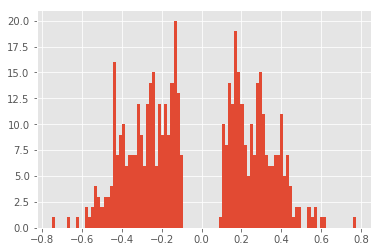

In [24]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=1)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

[ 0.11921283 -0.18316405  0.34380829  0.38719125 -0.18535384  0.42690672
  0.3727742   0.12577573 -0.42593638  0.2106069  -0.43661257  0.47217763
  0.24508204 -0.18203904 -0.39509825 -0.29988641 -0.33217628 -0.3478954
  0.17561105  0.20627133  0.19832862 -0.18213382 -0.39171507 -0.00962578
  0.43822818  0.12672241  0.40530802 -0.34789078  0.38411005  0.75248906
 -0.10703242  0.65992505  0.27051613  0.28215125 -0.22140993  0.14542765
  0.13728017 -0.1282111  -0.338517    0.45750862 -0.6517473   0.4703171
  0.3145637   0.25264917 -0.22853416  0.1357161  -0.12263858  0.16614736
 -0.31487655 -0.67621853 -0.32653803 -0.19655451  0.12325935 -0.05513834
  0.24940535 -0.23068516 -0.1698582   0.16785355 -0.16449229  0.06226676
 -0.35190802  0.28745353  0.16854508 -0.06899115 -0.026884   -0.27080399
 -0.04623953  0.33366397  0.24935609  0.28259276 -0.14350288 -0.10000801
 -0.52963672  0.11940301 -0.14254404 -0.35419465  0.28302669  0.01653314
  0.10928827  0.03230356 -0.14273742 -0.38227662  0.3

(array([  2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,
          2.,   0.,   1.,   2.,   1.,   0.,   1.,   1.,   1.,   1.,   2.,
          2.,   5.,   4.,   6.,   8.,   7.,   6.,   8.,   5.,  14.,   5.,
         10.,  12.,  10.,  11.,   8.,  11.,   9.,  12.,  22.,   7.,  14.,
         12.,   5.,   7.,  11.,   4.,   4.,   1.,   5.,   8.,   4.,   2.,
          2.,   7.,  13.,  18.,  11.,  16.,   5.,  14.,  11.,   7.,   9.,
          5.,   9.,   4.,   6.,   7.,  10.,   8.,  10.,   6.,   6.,   4.,
          8.,   8.,   5.,   6.,   0.,   1.,   2.,   0.,   0.,   2.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.82610896, -0.80997742, -0.79384587, -0.77771432, -0.76158277,
        -0.74545123, -0.72931968, -0.71318813, -0.69705658, -0.68092504,
        -0.66479349, -0.64866194, -0.6325304 , -0.61639885, -0.6002673 ,
        -0.58413575, -0.56800421, -0.55187266, -0.53574111, -0.51960956,
        -0.50347802, -0.48

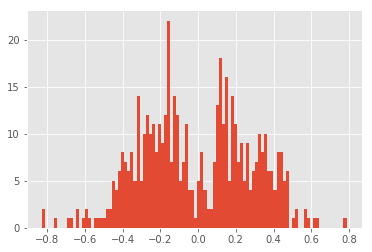

In [25]:
batch_generator=generateBatch(train_logs,batch_size = 250,threshhold=0.5)
batch_steering=get_steeringList(batch_generator,size=3)   
plt.hist(batch_steering.astype('float'),bins=100)

----

## Step 2: Design and Test a Model Architecture

1)first using the nvida paper model

In [15]:
# model design
import pickle
import numpy as np
import math
from keras.utils import np_utils
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout, Dense, Activation
from keras.optimizers import SGD, Adam
from keras.models import Sequential

model = Sequential()
inputShape = (66,200,3)
 # select elu because output can be less than zero 
model.add(Lambda(lambda x: x/255.-0.5,input_shape=inputShape,output_shape=inputShape,name="Normalization"))
model.add(Conv2D(24,5,5,subsample=(2,2), activation = 'elu', border_mode='valid',name='Conv2D1')) 
model.add(Dropout(0.3, name='DropoutC1'))
#output shape 31*98*24*3

model.add(Conv2D(36,5,5,subsample=(2,2), activation = 'elu',  border_mode='valid',name='Conv2D2'))
model.add(Dropout(0.3, name='DropoutC2'))
#output shape 14*47*36*3

model.add(Conv2D(48,5,5,subsample=(2,2), activation = 'elu', border_mode='valid', name='Conv2D3'))
model.add(Dropout(0.3, name='DropoutC3'))
#output shape 5*22*48*3

model.add(Conv2D(64,3,3,subsample=(1,1), activation = 'elu', border_mode='valid', name='Conv2D4'))
model.add(Dropout(0.3, name='DropoutC4'))
#output shape 3*20*64*3

model.add(Conv2D(64,3,3,subsample=(1,1), activation = 'elu', border_mode='valid', name='Conv2D5'))
model.add(Dropout(0.3, name='DropoutC5'))
#output shape 1*18*64*3

# convolution to dense,flatten layer  1152 nodes
model.add(Flatten(name='flatten'))

model.add(Dense(100,activation='elu', name='Dense1'))
model.add(Dropout(0.5, name='DropoutD1'))

model.add(Dense(50,activation='elu', name='Dense2'))
model.add(Dropout(0.5, name='DropoutD2'))

model.add(Dense(10,activation='elu', name='Dense3'))
model.add(Dropout(0.5, name='DropoutD3'))

model.add(Dense(1,activation='elu', name='Output')) # problem is a regression

model.summary()



Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv2D1 (Convolution2D)          (None, 31, 98, 24)    1824        Normalization[0][0]              
____________________________________________________________________________________________________
DropoutC1 (Dropout)              (None, 31, 98, 24)    0           Conv2D1[0][0]                    
____________________________________________________________________________________________________
Conv2D2 (Convolution2D)          (None, 14, 47, 36)    21636       DropoutC1[0][0]                  
___________________________________________________________________________________________

In [26]:
#adam = Adam(lr=1e-4)
#model.compile(loss='mse',optimizer=adam)
model.compile(optimizer="adam", loss="mse")


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
import json

numTimes = 5
numEpoch = 2
threshhold=1
for time in range(numTimes):
    train_logs, val_logs=log_select(zero_logs,none_zero_logs)
    trainGenerator = generateBatch(train_logs,250,threshhold)
    validGenerator = generateBatch(val_logs,250,threshhold)
    samplesPerEpoch = 50000 
    nbValSamples = 5000
    #history = model.fit_generator(trainGenerator, samplesPerEpoch, numEpoch, verbose=1)
    #history = model.fit_generator(trainGenerator, samplesPerEpoch, numEpoch,verbose=1, validation_data=validGenerator, nb_val_samples = nbValSamples,
    #                callbacks=[ModelCheckpoint(filepath="bestVal.h5", verbose=1, save_best_only=True), ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.000001)])
    history = model.fit_generator(trainGenerator, samples_per_epoch=samplesPerEpoch, nb_epoch=numEpoch, validation_data=validGenerator,
                   nb_val_samples=nbValSamples, callbacks=[ModelCheckpoint(filepath="bestVal"+str(time)+".h5", verbose=1, save_best_only=True)])
                
    #history = model.fit_generator(trainGenerator, samples_per_epoch=samplesPerEpoch, nb_epoch=numEpoch,  callbacks=[ModelCheckpoint(filepath="bestVal"+str(time)+".h5", verbose=1, save_best_only=True)])
                
    print('Time ',time+1)
    threshhold=threshhold/(time+1)

    
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved.")
  



Epoch 1/10
50000/50000 [==============================] - 3784s - loss: 0.1194 - val_loss: 0.0528
Epoch 2/10
50000/50000 [==============================] - 3585s - loss: 0.0645 - val_loss: 0.0477
Epoch 3/10
50000/50000 [==============================] - 3550s - loss: 0.0585 - val_loss: 0.0485
Epoch 4/10
50000/50000 [==============================] - 3588s - loss: 0.0547 - val_loss: 0.0451
Epoch 5/10
50000/50000 [==============================] - 3589s - loss: 0.0528 - val_loss: 0.0427
Epoch 6/10
50000/50000 [==============================] - 3917s - loss: 0.0520 - val_loss: 0.0467
Epoch 7/10
50000/50000 [==============================] - 4528s - loss: 0.0499 - val_loss: 0.0497
Epoch 8/10
50000/50000 [==============================] - 3881s - loss: 0.0495 - val_loss: 0.0417
Epoch 9/10
50000/50000 [==============================] - 4146s - loss: 0.0475 - val_loss: 0.0394
Epoch 10/10
50000/50000 [==============================] - 4048s - loss: 0.0463 - val_loss: 0.0381
Time  1
Epoch 1/10


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
import json

numTimes = 20
numEpoch = 10
#threshhold=0.1
for time in range(numTimes):
    
    trainGenerator = generateBatch(train_logs,500,threshhold)
    validGenerator = generateBatch(val_logs,500,threshhold)
    samplesPerEpoch = 50000 
    nbValSamples = 5000
    #history = model.fit_generator(trainGenerator, samplesPerEpoch, numEpoch, verbose=1)
    #history = model.fit_generator(trainGenerator, samplesPerEpoch, numEpoch,verbose=1, validation_data=validGenerator, nb_val_samples = nbValSamples,
    #                callbacks=[ModelCheckpoint(filepath="bestVal.h5", verbose=1, save_best_only=True), ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.000001)])
    history = model.fit_generator(trainGenerator, samples_per_epoch=samplesPerEpoch, nb_epoch=numEpoch, validation_data=validGenerator,
                   nb_val_samples=nbValSamples, callbacks=[ModelCheckpoint(filepath="bestVal"+str(time)+".h5", verbose=1, save_best_only=True)])
                
    #history = model.fit_generator(trainGenerator, samples_per_epoch=samplesPerEpoch, nb_epoch=numEpoch,  callbacks=[ModelCheckpoint(filepath="bestVal"+str(time)+".h5", verbose=1, save_best_only=True)])
                
    print('Time ',time+1)
    threshhold=threshhold/(time+1)

    
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved.")

In [41]:
# visualize model layers output
from keras import backend as K
layerOutput = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[2].output])
idx = 5000 
#test = train_data_directory +logs[idx][0].split("IMG/")[1].strip()
image= mpimg.imread(train_data_directory +logs[idx][0].split("IMG/")[1].strip())
image=preprocessImage(image)
testLabel=float(logs[idx][3].strip())

# output in test mode = 0, train mode = 1
layerOutputSample = layerOutput([image.reshape(1,image.shape[0],image.shape[1],image.shape[2]), 1])[0]
layerOutputSample = layerOutputSample.reshape(layerOutputSample.shape[1],layerOutputSample.shape[2],layerOutputSample.shape[3])

(31, 98, 24)


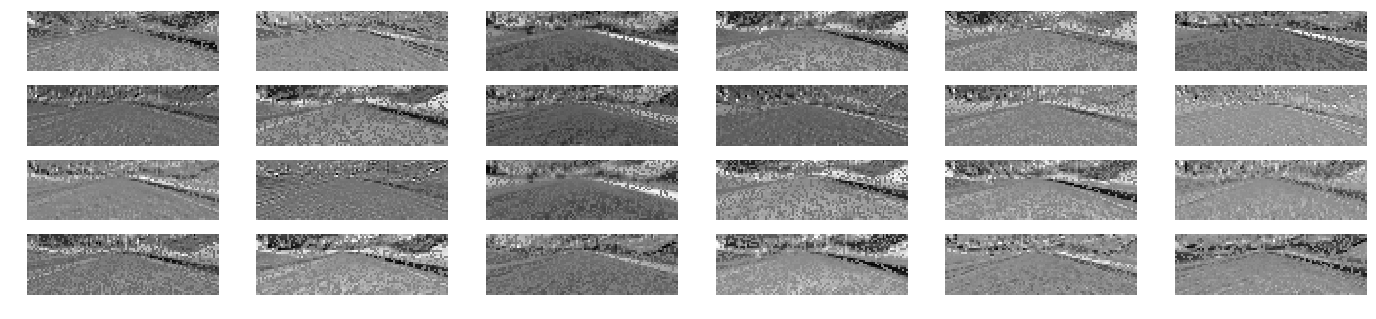

In [42]:
print(layerOutputSample.shape)
figure = plt.figure(figsize=(24,8))
factors = [6,6]
for ind in range(layerOutputSample.shape[2]):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    #plt.subplot(4, 4, ind + 1)
    val = layerOutputSample[:,:,ind]
    plt.axis("off")
    plt.imshow(val, cmap='gray',interpolation='nearest')

In [38]:
print(model.layers[1].get_weights()[0].shape) # the weights

(5, 5, 3, 24)


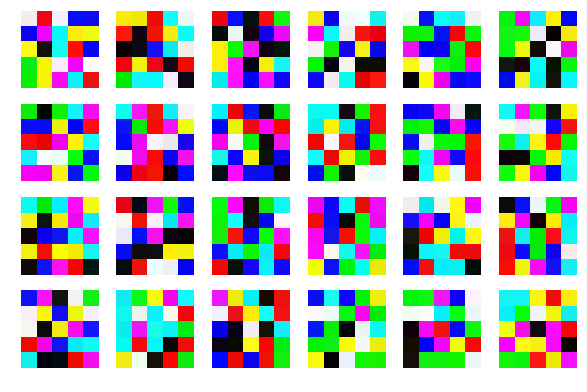

In [40]:
import pylab as pl
# source: http://euler.stat.yale.edu/~tba3/stat665/lectures/lec17/notebook17.html
weight = model.layers[1].get_weights()[0]
plt.figure(figsize=(10, 10), frameon=False)
for ind in range(weight.shape[3]):
    plt.subplot(6, 6, ind + 1)
    val = weight[:,:,:,ind]
    #print(val.shape)
    #im = val.reshape((3,3))
    plt.axis("off")
    plt.imshow(val,interpolation='nearest')

In [36]:
# save the model
import json
#import simplejson
jsonString = model.to_json() # json Model
with open('./model.json', 'w') as outFile:
    outFile.write(jsonString)
    # json.dump(jsonString, outFile)

model.save_weights('./model.h5') #  HDF5 file

In [37]:
# load the model
from keras.models import model_from_json
jsonFile = './model.json'
with open(jsonFile, 'r') as jfile:
    #model = model_from_json(json.load(jfile))
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
weights_file = jsonFile.replace('json', 'h5')
model.load_weights(weights_file)